# GEO Satellite Risk Scoring System
## Focused on Geostationary Orbit 

This notebook:
- Fetches GEO satellite TLE data
- Applies multi-layer filtering to remove non-GEO satellites
- Propagates orbits using SGP4
- Detects anomalies with Isolation Forest
- Generates risk scores for station-keeping issues

---

## 1. Setup and Imports

In [35]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sgp4.api import Satrec, jday
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Configuration

In [36]:
# Your Space-Track credentials
USERNAME = "ethansoc18@gmail.com"
PASSWORD = "Soccerlover2005!"

# GEO-specific parameters
NUM_GEO_SATELLITES = 500
DAYS_BACK = 7
PROPAGATION_HOURS = 48
TIME_STEP_MINUTES = 120
CONTAMINATION = 0.12

# GEO orbit definition
GEO_MEAN_MOTION_MIN = 0.9
GEO_MEAN_MOTION_MAX = 1.1

## 3. Connect to Space-Track API

In [37]:
# Create session and login
session = requests.Session()
login_url = "https://www.space-track.org/ajaxauth/login"
resp = session.post(login_url, data={"identity": USERNAME, "password": PASSWORD})

if resp.status_code != 200:
    raise RuntimeError(f"Login failed: {resp.status_code}")

## 4. Fetch GEO Satellites with Improved Filtering

**New filters:**
- Eccentricity < 0.05 (very circular)
- Inclination < 15° (near-equatorial)
- Period: 1400-1500 minutes

In [38]:
# Build query with STRICT GEO criteria
base_url = "https://www.space-track.org/basicspacedata/query/class/gp/format/json"

query_parts = [
    base_url,
    f"EPOCH/>now-{DAYS_BACK}",
    "OBJECT_TYPE/PAYLOAD",
    f"MEAN_MOTION/<{GEO_MEAN_MOTION_MAX}",
    f"MEAN_MOTION/>{GEO_MEAN_MOTION_MIN}",
    "ECCENTRICITY/<0.05",
    "INCLINATION/<15",
    "PERIOD/>1400",
    "PERIOD/<1500",
    "orderby/EPOCH desc",
    f"limit/{NUM_GEO_SATELLITES * 2}"
]

query_url = '/'.join(query_parts)

resp = session.get(query_url)
if resp.status_code != 200:
    raise RuntimeError(f"TLE fetch failed: {resp.status_code}")

tle_data = resp.json()
tle_df = pd.DataFrame(tle_data)

print(f"\nRetrieved {len(tle_df)} satellites from API")


Retrieved 1000 satellites from API


## 5. Post-Processing Filters

Apply additional filters to remove non-GEO satellites

In [39]:
print("Applying post-processing filters...")

# Convert to numeric
numeric_cols = ['MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'NORAD_CAT_ID', 'PERIOD']
for col in numeric_cols:
    if col in tle_df.columns:
        tle_df[col] = pd.to_numeric(tle_df[col], errors='coerce')

# Calculate orbital parameters
mean_motion_rad_per_sec = tle_df['MEAN_MOTION'] * 2 * np.pi / 86400
semi_major_axis = (398600.4418 / mean_motion_rad_per_sec**2)**(1/3)
tle_df['APPROX_ALTITUDE_KM'] = semi_major_axis - 6371
tle_df['PERIGEE_ALT'] = semi_major_axis * (1 - tle_df['ECCENTRICITY']) - 6371
tle_df['APOGEE_ALT'] = semi_major_axis * (1 + tle_df['ECCENTRICITY']) - 6371
tle_df['ALTITUDE_VARIATION'] = tle_df['APOGEE_ALT'] - tle_df['PERIGEE_ALT']

initial_count = len(tle_df)

# Filter 1: Altitude range
tle_df = tle_df[(tle_df['APPROX_ALTITUDE_KM'] >= 32000) & (tle_df['APPROX_ALTITUDE_KM'] <= 39000)]
print(f"\nFilter 1 - Altitude (32-39k km): Removed {initial_count - len(tle_df)}, Remaining: {len(tle_df)}")

# Filter 2: Perigee (KEY - removes HEO satellites)
f2_before = len(tle_df)
tle_df = tle_df[tle_df['PERIGEE_ALT'] >= 30000]
print(f"Filter 2 - Perigee (>30k km): Removed {f2_before - len(tle_df)} HEO satellites, Remaining: {len(tle_df)}")

# Filter 3: Altitude variation
f3_before = len(tle_df)
tle_df = tle_df[tle_df['ALTITUDE_VARIATION'] <= 5000]
print(f"Filter 3 - Variation (<5k km): Removed {f3_before - len(tle_df)}, Remaining: {len(tle_df)}")

# Filter 4: Quality selection
if len(tle_df) > NUM_GEO_SATELLITES:
    tle_df['GEO_QUALITY'] = abs(tle_df['APPROX_ALTITUDE_KM'] - 35786)
    tle_df = tle_df.nsmallest(NUM_GEO_SATELLITES, 'GEO_QUALITY')

tle_df = tle_df.reset_index(drop=True)

print(f"FILTERING COMPLETE: {initial_count} → {len(tle_df)} satellites")
print(f"Removed {initial_count - len(tle_df)} non-GEO satellites")

Applying post-processing filters...

Filter 1 - Altitude (32-39k km): Removed 23, Remaining: 977
Filter 2 - Perigee (>30k km): Removed 0 HEO satellites, Remaining: 977
Filter 3 - Variation (<5k km): Removed 0, Remaining: 977
FILTERING COMPLETE: 1000 → 500 satellites
Removed 500 non-GEO satellites


In [40]:
# Display filtered satellites
print("\nSample of filtered GEO satellites:\n")
print(tle_df[['OBJECT_NAME', 'APPROX_ALTITUDE_KM', 'PERIGEE_ALT', 'APOGEE_ALT', 'ECCENTRICITY']].head(10))

print(f"\nOrbital Statistics:")
print(f"  Mean altitude: {tle_df['APPROX_ALTITUDE_KM'].mean():.2f} km")
print(f"  Std deviation: {tle_df['APPROX_ALTITUDE_KM'].std():.2f} km")
print(f"  Mean eccentricity: {tle_df['ECCENTRICITY'].mean():.6f}")
print(f"  Mean inclination: {tle_df['INCLINATION'].mean():.2f}°")


Sample of filtered GEO satellites:

                OBJECT_NAME  APPROX_ALTITUDE_KM   PERIGEE_ALT    APOGEE_ALT  \
0  TELSTAR 4 (TELSTAR 402R)        35786.183073  35764.889480  35807.476666   
1                  RADUGA 3        35785.307997  35747.156538  35823.459456   
2                 RADUGA 14        35787.266683  35786.625877  35787.907489   
3             INTELSAT 2-F3        35784.557928  35699.074888  35870.040969   
4                     ASC 1        35783.977397  35775.803547  35792.151248   
5           UFO 8 (USA 138)        35788.085532  35753.831275  35822.339789   
6                   DFH-3 2        35788.807171  35777.124689  35800.489654   
7                    GALS 1        35788.913949  35740.025313  35837.802585   
8               COSMOS 1366        35788.973083  35758.508286  35819.437879   
9                   EKRAN 2        35789.087989  35601.829742  35976.346236   

   ECCENTRICITY  
0      0.000505  
1      0.000905  
2      0.000015  
3      0.002028  
4  

## 6. Visualize Filtered GEO Satellites

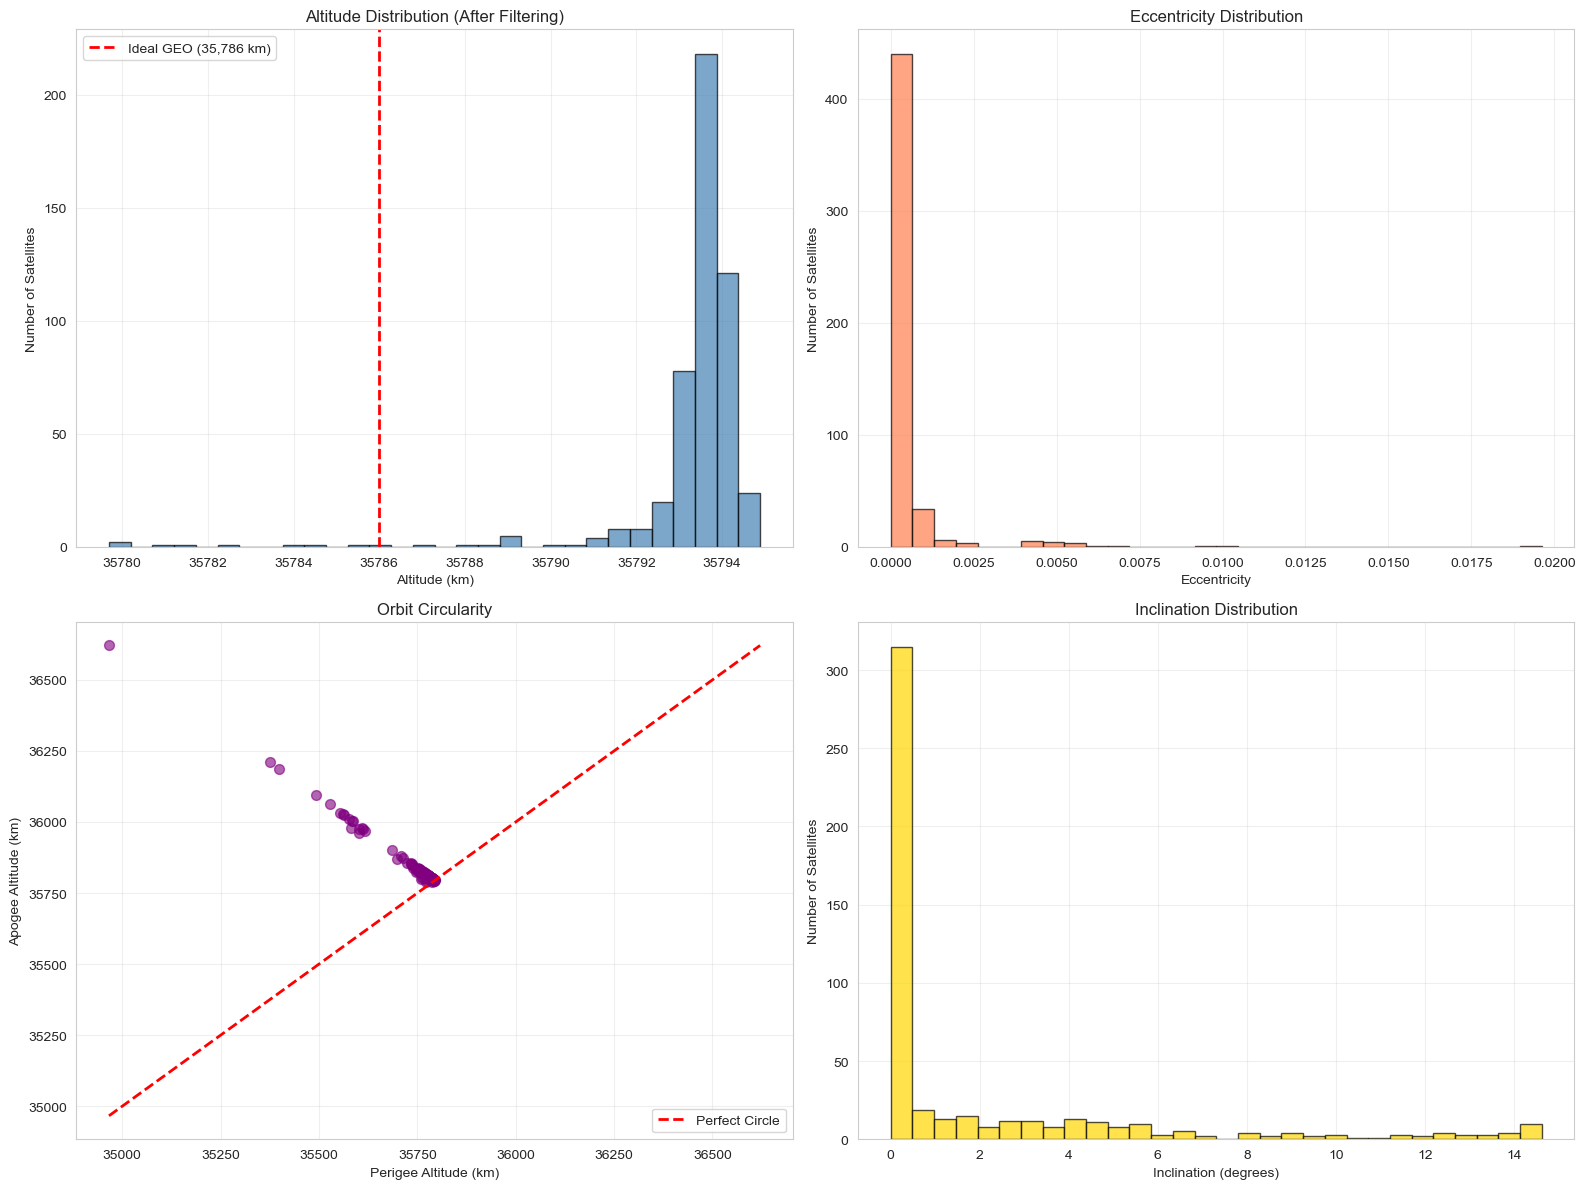

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Altitude distribution
axes[0, 0].hist(tle_df['APPROX_ALTITUDE_KM'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(35786, color='red', linestyle='--', linewidth=2, label='Ideal GEO (35,786 km)')
axes[0, 0].set_xlabel('Altitude (km)')
axes[0, 0].set_ylabel('Number of Satellites')
axes[0, 0].set_title('Altitude Distribution (After Filtering)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Eccentricity
axes[0, 1].hist(tle_df['ECCENTRICITY'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Eccentricity')
axes[0, 1].set_ylabel('Number of Satellites')
axes[0, 1].set_title('Eccentricity Distribution')
axes[0, 1].grid(alpha=0.3)

# Perigee vs Apogee
axes[1, 0].scatter(tle_df['PERIGEE_ALT'], tle_df['APOGEE_ALT'], alpha=0.6, s=50, color='purple')
min_alt = tle_df['PERIGEE_ALT'].min()
max_alt = tle_df['APOGEE_ALT'].max()
axes[1, 0].plot([min_alt, max_alt], [min_alt, max_alt], 'r--', linewidth=2, label='Perfect Circle')
axes[1, 0].set_xlabel('Perigee Altitude (km)')
axes[1, 0].set_ylabel('Apogee Altitude (km)')
axes[1, 0].set_title('Orbit Circularity')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Inclination
axes[1, 1].hist(tle_df['INCLINATION'], bins=30, edgecolor='black', alpha=0.7, color='gold')
axes[1, 1].set_xlabel('Inclination (degrees)')
axes[1, 1].set_ylabel('Number of Satellites')
axes[1, 1].set_title('Inclination Distribution')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Initialize SGP4 Satellites

In [42]:
satellites = []

for idx, row in tle_df.iterrows():
    try:
        sat = Satrec.twoline2rv(row['TLE_LINE1'], row['TLE_LINE2'])
        satellites.append({
            'norad_id': row['NORAD_CAT_ID'],
            'object_name': row['OBJECT_NAME'],
            'mean_motion': row['MEAN_MOTION'],
            'eccentricity': row['ECCENTRICITY'],
            'inclination': row['INCLINATION'],
            'sat_obj': sat
        })
    except Exception as e:
        print(f"Warning: Failed {row['OBJECT_NAME']}: {e}")

print(f"Initialized {len(satellites)} satellites")

Initialized 500 satellites


## 8. Propagate Orbits and Extract Features

In [43]:
def propagate_satellite(sat_obj, duration_hours=48, step_minutes=120):
    positions = []
    start_time = datetime.utcnow()
    num_steps = int(duration_hours * 60 / step_minutes)
    
    for i in range(num_steps):
        current_time = start_time + timedelta(minutes=i * step_minutes)
        jd, fr = jday(current_time.year, current_time.month, current_time.day,
                     current_time.hour, current_time.minute, current_time.second)
        error_code, r, v = sat_obj.sgp4(jd, fr)
        
        if error_code == 0:
            positions.append({
                'x': r[0], 'y': r[1], 'z': r[2],
                'vx': v[0], 'vy': v[1], 'vz': v[2]
            })
    return positions

In [44]:
def extract_features(propagation_data):
    if not propagation_data:
        return None
    
    positions = np.array([[p['x'], p['y'], p['z']] for p in propagation_data])
    velocities = np.array([[p['vx'], p['vy'], p['vz']] for p in propagation_data])
    
    EARTH_RADIUS_KM = 6371.0
    altitudes = np.linalg.norm(positions, axis=1) - EARTH_RADIUS_KM
    velocity_mags = np.linalg.norm(velocities, axis=1)
    angular_momentum = np.cross(positions, velocities)
    angular_momentum_mag = np.linalg.norm(angular_momentum, axis=1)
    altitude_deviation = np.abs(altitudes - 35786.0)
    
    return {
        'mean_altitude': np.mean(altitudes),
        'altitude_std': np.std(altitudes),
        'min_altitude': np.min(altitudes),
        'max_altitude': np.max(altitudes),
        'altitude_range': np.max(altitudes) - np.min(altitudes),
        'mean_velocity': np.mean(velocity_mags),
        'velocity_std': np.std(velocity_mags),
        'mean_angular_momentum': np.mean(angular_momentum_mag),
        'angular_momentum_std': np.std(angular_momentum_mag),
        'position_variation': np.std(positions, axis=0).mean(),
        'velocity_variation': np.std(velocities, axis=0).mean(),
        'geo_altitude_deviation': np.mean(altitude_deviation),
        'max_geo_altitude_deviation': np.max(altitude_deviation)
    }

In [45]:
print(f"Propagating {len(satellites)} satellite orbits...")

feature_list = []
start_time = time.time()

for i, sat_data in enumerate(satellites):
    if (i + 1) % 25 == 0 or (i + 1) == len(satellites):
        elapsed = time.time() - start_time
        rate = (i + 1) / elapsed if elapsed > 0 else 0
        remaining = (len(satellites) - (i + 1)) / rate if rate > 0 else 0
        print(f"  Progress: {i+1}/{len(satellites)} ({100*(i+1)/len(satellites):.1f}%) - ETA: {remaining:.0f}s")
    
    try:
        positions = propagate_satellite(sat_data['sat_obj'], PROPAGATION_HOURS, TIME_STEP_MINUTES)
        features = extract_features(positions)
        
        if features:
            features['norad_id'] = sat_data['norad_id']
            features['object_name'] = sat_data['object_name']
            features['mean_motion'] = sat_data['mean_motion']
            features['eccentricity'] = sat_data['eccentricity']
            features['inclination'] = sat_data['inclination']
            feature_list.append(features)
    except Exception as e:
        print(f"  Warning: Failed {sat_data['object_name']}: {e}")

feature_df = pd.DataFrame(feature_list)
total_time = time.time() - start_time

print(f"\nExtracted features from {len(feature_df)} satellites")
print(f"Total time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")

Propagating 500 satellite orbits...
  Progress: 25/500 (5.0%) - ETA: 0s
  Progress: 50/500 (10.0%) - ETA: 0s
  Progress: 75/500 (15.0%) - ETA: 0s
  Progress: 100/500 (20.0%) - ETA: 0s
  Progress: 125/500 (25.0%) - ETA: 0s
  Progress: 150/500 (30.0%) - ETA: 0s
  Progress: 175/500 (35.0%) - ETA: 0s
  Progress: 200/500 (40.0%) - ETA: 0s
  Progress: 225/500 (45.0%) - ETA: 0s
  Progress: 250/500 (50.0%) - ETA: 0s
  Progress: 275/500 (55.0%) - ETA: 0s
  Progress: 300/500 (60.0%) - ETA: 0s
  Progress: 325/500 (65.0%) - ETA: 0s
  Progress: 350/500 (70.0%) - ETA: 0s
  Progress: 375/500 (75.0%) - ETA: 0s
  Progress: 400/500 (80.0%) - ETA: 0s
  Progress: 425/500 (85.0%) - ETA: 0s
  Progress: 450/500 (90.0%) - ETA: 0s
  Progress: 475/500 (95.0%) - ETA: 0s
  Progress: 500/500 (100.0%) - ETA: 0s

Extracted features from 500 satellites
Total time: 0.1 seconds (0.0 minutes)


## 9. Train Isolation Forest Model

In [46]:
feature_columns = [
    'mean_altitude', 'altitude_std', 'altitude_range',
    'mean_velocity', 'velocity_std',
    'mean_angular_momentum', 'angular_momentum_std',
    'position_variation', 'velocity_variation',
    'geo_altitude_deviation', 'max_geo_altitude_deviation'
]

X = feature_df[feature_columns].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
model = IsolationForest(contamination=CONTAMINATION, random_state=42, n_estimators=100)
model.fit(X_scaled)

IsolationForest(contamination=0.12, random_state=42)

## 10. Generate Risk Scores

In [47]:
predictions = model.predict(X_scaled)
anomaly_scores = model.score_samples(X_scaled)

min_score = anomaly_scores.min()
max_score = anomaly_scores.max()
risk_scores = 100 * (1 - (anomaly_scores - min_score) / (max_score - min_score))

feature_df['anomaly_prediction'] = predictions
feature_df['anomaly_score'] = anomaly_scores
feature_df['risk_score'] = risk_scores
feature_df['is_anomaly'] = (predictions == -1)

feature_df = feature_df.sort_values('risk_score', ascending=False).reset_index(drop=True)

## 11. Results

In [48]:
print("GEO SATELLITE RISK SCORING RESULTS")

print(f"\nTotal satellites: {len(feature_df)}")
print(f"Anomalies: {feature_df['is_anomaly'].sum()} ({100*feature_df['is_anomaly'].mean():.1f}%)")
print(f"\nRisk Score Stats:")
print(f"  Mean: {feature_df['risk_score'].mean():.2f}")
print(f"  Median: {feature_df['risk_score'].median():.2f}")
print(f"  Max: {feature_df['risk_score'].max():.2f}")

GEO SATELLITE RISK SCORING RESULTS

Total satellites: 500
Anomalies: 60 (12.0%)

Risk Score Stats:
  Mean: 14.18
  Median: 8.36
  Max: 100.00


In [49]:
print("\nTOP 10 HIGHEST RISK SATELLITES:\n")
feature_df.head(10)[['object_name', 'norad_id', 'risk_score', 'is_anomaly', 'mean_altitude', 'geo_altitude_deviation']]


TOP 10 HIGHEST RISK SATELLITES:



,object_name,norad_id,risk_score,is_anomaly,mean_altitude,geo_altitude_deviation
0,MUOS 5,41622,100.000000,True,35801.729784,523.105010
1,USA 169,27711,88.206916,True,35796.418045,261.646463
2,HGS 1 (ASIASAT 3),25126,80.961180,True,35780.811880,124.624015
3,AEHF 3 (USA 246),39256,80.354901,True,35792.860236,252.508208
4,EKRAN 3,11273,78.053498,True,35781.565157,115.545404
5,AEHF 5 (USA 292),44481,75.983266,True,35795.635994,191.585272
6,AEHF 4 (USA 288),43651,70.875999,True,35794.376583,168.299071
7,STTW-4,20473,70.532635,True,35779.264181,6.951783
8,ACTS,22796,68.715768,True,35794.200164,132.500475
9,INTELSAT 2-F3,2717,67.610496,True,35784.161486,54.938464


In [50]:
print("\nBOTTOM 10 LOWEST RISK SATELLITES:\n")
feature_df.tail(10)[['object_name', 'norad_id', 'risk_score', 'is_anomaly', 'mean_altitude', 'geo_altitude_deviation']]


BOTTOM 10 LOWEST RISK SATELLITES:



,object_name,norad_id,risk_score,is_anomaly,mean_altitude,geo_altitude_deviation
490,NIMIQ 5,35873,0.845988,False,35793.427670,8.426093
491,SES 5,38652,0.817827,False,35793.179815,7.441738
492,HOTBIRD 13F,54048,0.788145,False,35793.341679,7.770598
493,NIMIQ 4,33373,0.599981,False,35793.249331,7.876947
494,TELSTAR 14R,37602,0.595154,False,35793.226175,7.882185
495,STARONE C4,40733,0.557858,False,35793.277145,8.464068
496,ARSAT 2,40941,0.557620,False,35793.321833,7.394827
497,TELSTAR 11N,34111,0.422284,False,35793.308594,7.798367
498,GALAXY 37,57493,0.162976,False,35793.254891,7.475048
499,STARONE C3,38991,0.000000,False,35793.245160,7.649356


## 12. Visualize Results

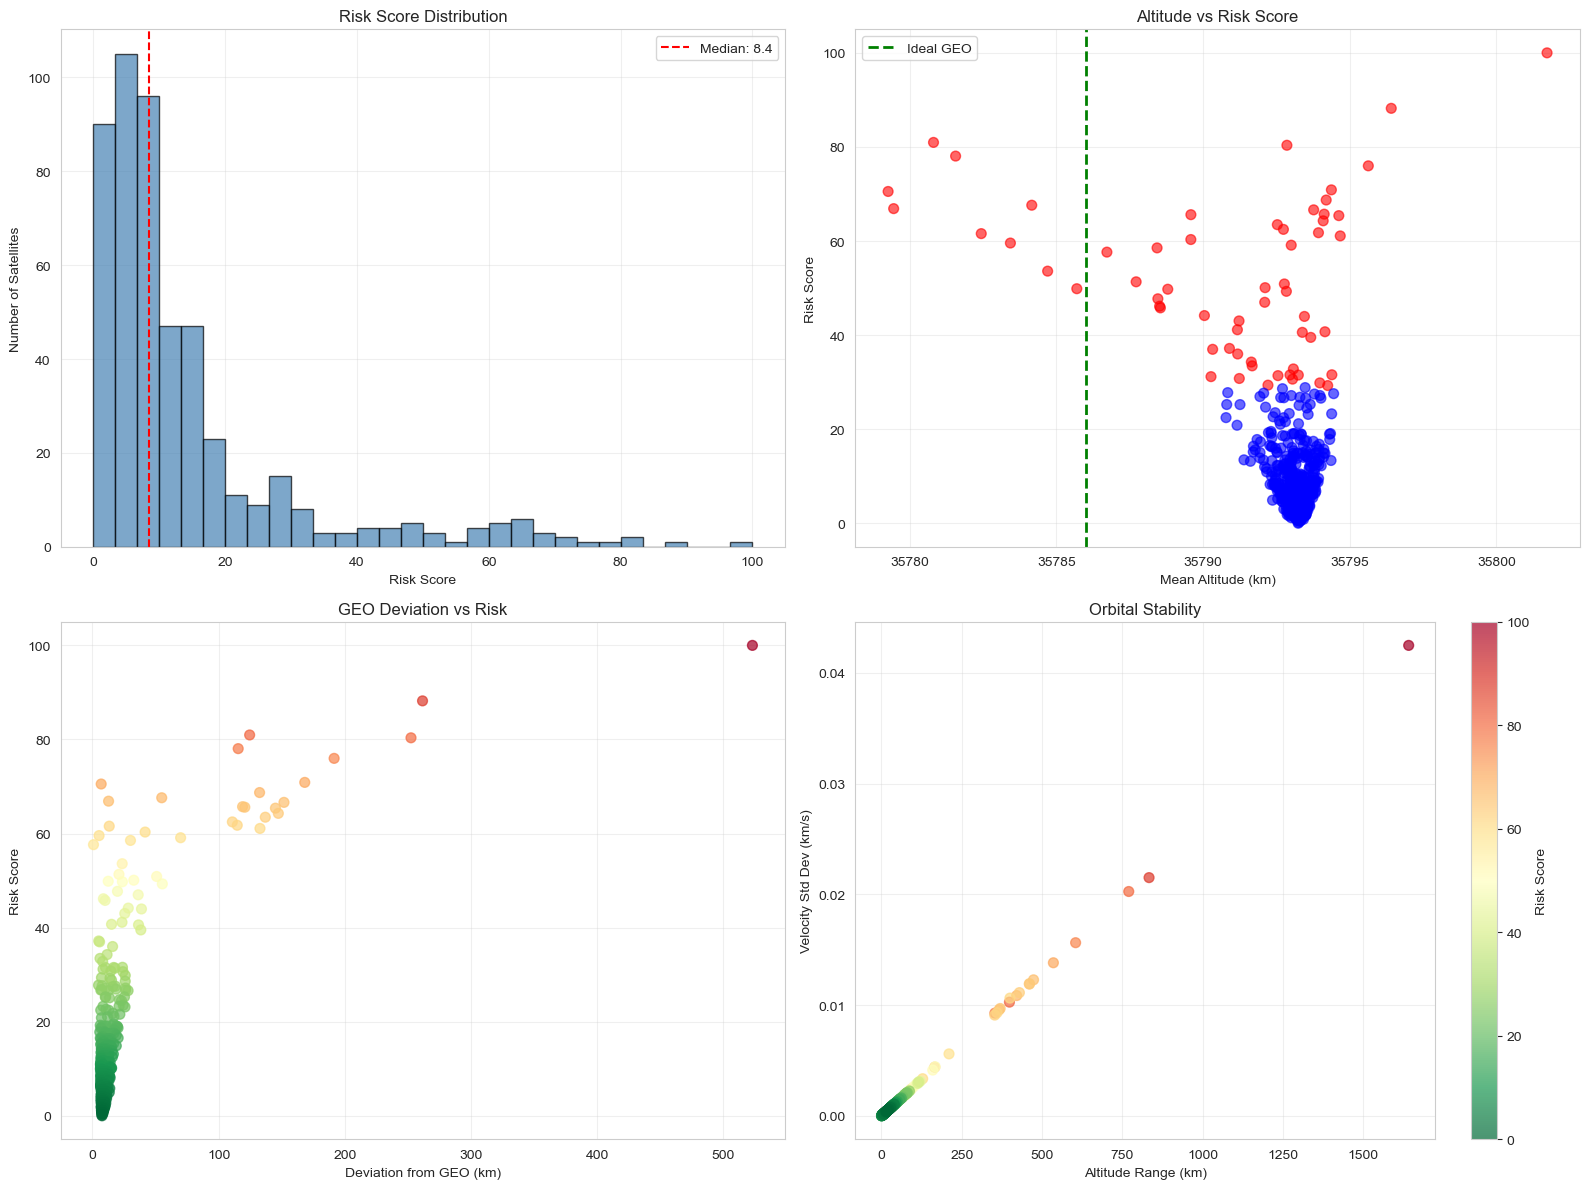

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Risk distribution
axes[0, 0].hist(feature_df['risk_score'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(feature_df['risk_score'].median(), color='red', linestyle='--', label=f'Median: {feature_df["risk_score"].median():.1f}')
axes[0, 0].set_xlabel('Risk Score')
axes[0, 0].set_ylabel('Number of Satellites')
axes[0, 0].set_title('Risk Score Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Altitude vs Risk
colors = ['red' if x else 'blue' for x in feature_df['is_anomaly']]
axes[0, 1].scatter(feature_df['mean_altitude'], feature_df['risk_score'], c=colors, alpha=0.6, s=50)
axes[0, 1].axvline(35786, color='green', linestyle='--', linewidth=2, label='Ideal GEO')
axes[0, 1].set_xlabel('Mean Altitude (km)')
axes[0, 1].set_ylabel('Risk Score')
axes[0, 1].set_title('Altitude vs Risk Score')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# GEO deviation vs Risk
axes[1, 0].scatter(feature_df['geo_altitude_deviation'], feature_df['risk_score'],
                   c=feature_df['risk_score'], cmap='RdYlGn_r', s=50, alpha=0.7)
axes[1, 0].set_xlabel('Deviation from GEO (km)')
axes[1, 0].set_ylabel('Risk Score')
axes[1, 0].set_title('GEO Deviation vs Risk')
axes[1, 0].grid(alpha=0.3)

# Orbital stability
scatter = axes[1, 1].scatter(feature_df['altitude_range'], feature_df['velocity_std'],
                             c=feature_df['risk_score'], cmap='RdYlGn_r', s=50, alpha=0.7)
axes[1, 1].set_xlabel('Altitude Range (km)')
axes[1, 1].set_ylabel('Velocity Std Dev (km/s)')
axes[1, 1].set_title('Orbital Stability')
plt.colorbar(scatter, ax=axes[1, 1], label='Risk Score')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()